### Emittance growth for bunch splitted in longitudinal slices, as a function of the center of the bunch.


- **Plot the emittance and emittance growth for each one of the longitudinal slices of the bunch as a function of the initial z position of the center of each slice.**
- The simulation needs to be performed with frozen longitudinal motion. 
- The file.pkl needs to contain the emittance values for each slice at each turn. 

In [98]:
import sys
sys.path.append('../../utils/')

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from PyHEADTAIL.particles.slicing import UniformBinSlicer

In [99]:
params = {'legend.fontsize': 20,
          'figure.figsize': (9.5, 8.5),
          'axes.labelsize': 27,
          'axes.titlesize': 23,
          'xtick.labelsize': 27,
          'ytick.labelsize': 27,
          'image.cmap': 'jet',
          'lines.linewidth': 2,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

In [100]:
# https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-sci
def moving_average(x, window):
    return np.convolve(x, np.ones(window), 'valid') / window

In [101]:
path_to_studies = './'

In [102]:
# study parameters
n_runs = 1 # number of runs that the simulation was repeated
n_turns = int(1e5)            # number of cycles to run the simulation for
decTurns = int(100)           # how often to record data
n_slices = 500
sigma_z = 0.155 # m

### Load emittances and initial bunch distribution

In [103]:
emitY_perSlice = pickle.load(open(path_to_studies+'file.pkl', 'rb'))

In [104]:
#Load the bunch, you need to activate a Pyheadtail version v1.13 or newer
bunch = pickle.load(open(path_to_studies+'bunch', 'rb')) # you need to activate an environment with pyhedtail version at least v1.13.path_to_studies

### For each slice get the initial z (of the center of the slice) 

As the longitudinal motion is frozen, z remains constant

In [105]:
# Use the same slicer as you used for the simulation
slicer_for_wakefields = UniformBinSlicer(n_slices, z_cuts=(-3.*sigma_z, 3.*sigma_z))

In [106]:
my_sliceSet = bunch.get_slices(slicer_for_wakefields) # type; PyHEADTAIL.particles.slicing.SliceSet
z_centers = my_sliceSet.z_centers

### Plot emittances for each slice of the initial distribution

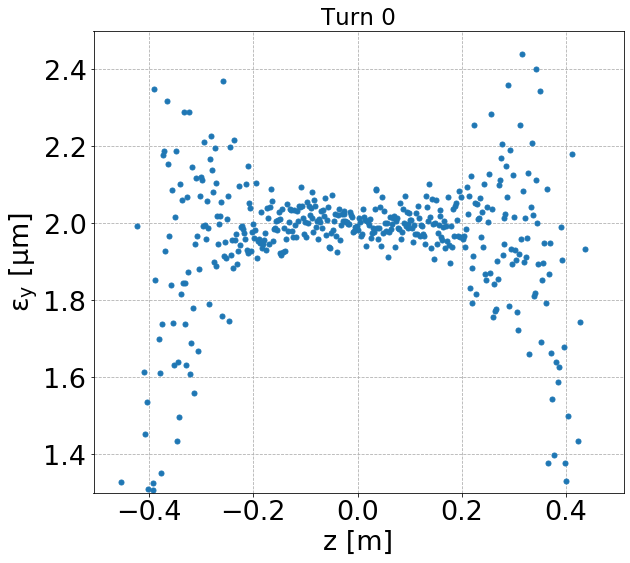

In [107]:
selected_turn = 0
plt.plot(z_centers, np.array(emitY_perSlice[selected_turn])*1e6, 'o')
plt.xlabel('z [m]')
plt.ylabel(r'$\mathrm{\epsilon_y \ [\mu m]}$')
plt.grid(linestyle='dashed')
plt.title(f'Turn {selected_turn}')
plt.ylim(1.3, 2.5)

savefig = False
if savefig:
    plt.savefig('eyVSzInit_initialDistribution.png', bbox_inches='tight')

### Remove the first and last 150 slices

- Larger emittance is obtained for the slices of the head and the tail of the beam.
- Larger statistical uncertainty than in the center of the beam due to the small number of particles in these slices (6D gaussian distribution)
- Thus, the first and last 150 slices will be excluded from the following analysis


In [108]:
selected_turn = 0
n_remove_slices = 150

new_z_centers = z_centers[n_remove_slices:-n_remove_slices]
new_emitY = emitY_perSlice[selected_turn][n_remove_slices:-n_remove_slices]

(1.3, 2.5)

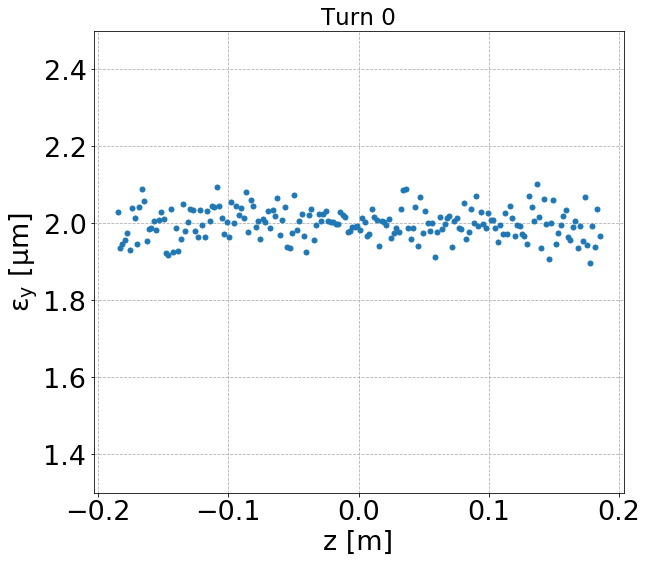

In [109]:
plt.plot(new_z_centers, np.array(new_emitY)*1e6, 'o')
plt.xlabel('z [m]')
plt.ylabel(r'$\mathrm{\epsilon_y \ [\mu m]}$')
plt.grid(linestyle='dashed')
plt.title(f'Turn {selected_turn}')
plt.ylim(1.3, 2.5)

### Moving average

- To smoothen out the fluctuations of the emittance values in the center of the bunch, a moving average is used for the following analysis.


In [110]:
selected_turn = 0
emitY_moving_average = moving_average(new_emitY, window=20)

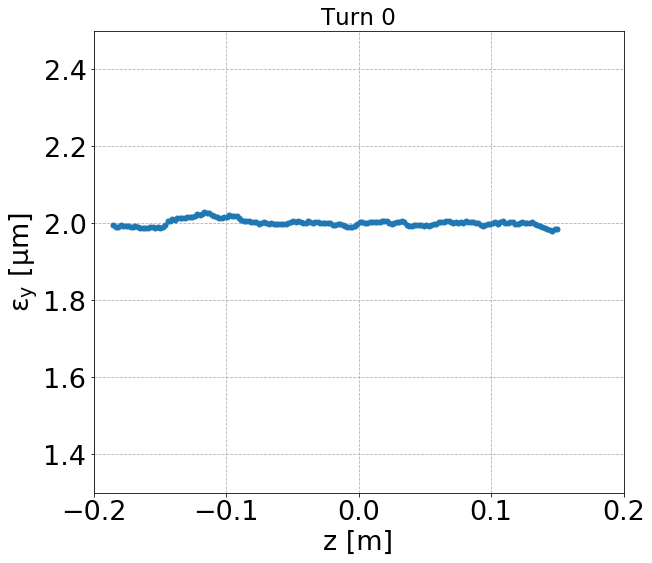

In [111]:
plt.plot(new_z_centers[:-19], np.array(emitY_moving_average)*1e6, 'o')
plt.xlabel('z [m]')
plt.ylabel(r'$\mathrm{\epsilon_y \ [\mu m]}$')
plt.grid(linestyle='dashed')
plt.title(f'Turn {selected_turn}')
plt.ylim(1.3, 2.5)
plt.xlim(-0.2, 0.2)


savefig = False
if savefig:
    plt.savefig('eyVSzInit_initialDistribution_MovingAverage.png', bbox_inches='tight')

### Plot emittance per slice for selected turns
- After removing the first and last 150 slices and performin a moving average, window 20, for the slices of the center of the bunch.

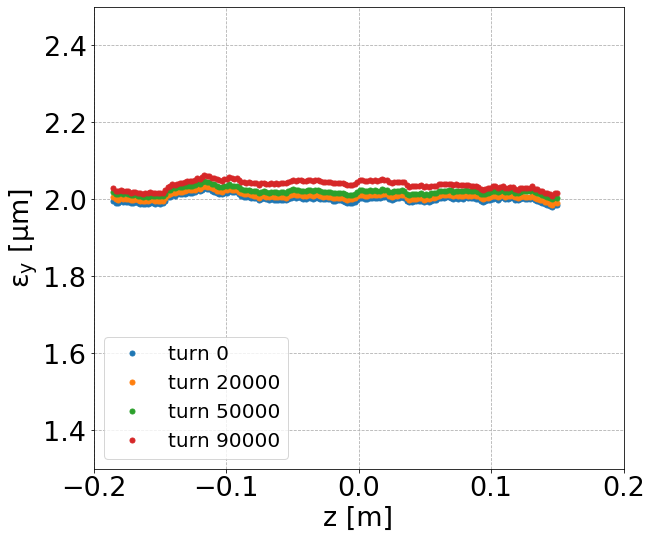

In [112]:
selected_turns = [0, 200, 500, 900]
n_remove_slices = 150 
new_z_centers = z_centers[n_remove_slices:-n_remove_slices]
for selected_turn in selected_turns:
    new_emitY = emitY_perSlice[selected_turn][n_remove_slices:-n_remove_slices]
    emitY_moving_average = moving_average(new_emitY, window=20)
    plt.plot(new_z_centers[:-19], np.array(emitY_moving_average)*1e6, 'o', label=f'turn {selected_turn*decTurns}')

plt.xlabel('z [m]')
plt.ylabel(r'$\mathrm{\epsilon_y \ [\mu m]}$')
plt.grid(linestyle='dashed')
plt.ylim(1.3, 2.5)
plt.xlim(-0.2, 0.2)
plt.legend(loc=3)


savefig = False
if savefig:
    plt.savefig('eyVSzInit_MovingAverage_SelectedTurns.png', bbox_inches='tight')

### Compute growth rate for each one of the slices
- After removing the first and last 150 slices and performin a moving average, window 20, for the slices of the center of the bunch.

In [115]:
n_remove_slices = 150 
emitY_perSlice_dict = {}

new_z_centers = z_centers[n_remove_slices:-n_remove_slices][:-19] # new slices after removing the ones from head and tail

for index, selected_slice in enumerate(new_z_centers):
    emitY_perSlice_dict[f'slice {index}'] = []

In [116]:
for selected_turn in range(int(n_turns/decTurns)):   
    
    new_emitY = emitY_perSlice[selected_turn][n_remove_slices:-n_remove_slices] # slices with removed head and tail
    emitY_moving_average = moving_average(new_emitY, window=20)
    
    for index, selected_slice in enumerate(new_z_centers):   
        emitY_perSlice_dict[f'slice {index}'].append(emitY_moving_average[index])
        #emitY_perSlice_dict[f'slice {index}'].append(new_emitY[index])
        #emitY_perSlice_dict[f'slice {index}']=emitY_moving_average[index]

### Plot emittance growth for selected z values

In [117]:
circumference  = 6911.5623 # [m]
f_rev  = 299792458/circumference  # [Hz] The revolution frequency of the machine 
separationTime = 1 / f_rev * decTurns #There are decTurns revolutions before each recording of data
tspan = (np.arange(n_turns / decTurns) + 1.0) * separationTime #total time spanned by the simulation

[  0.  18.  36.  54.  72.  90. 108. 126. 144. 162. 180.]


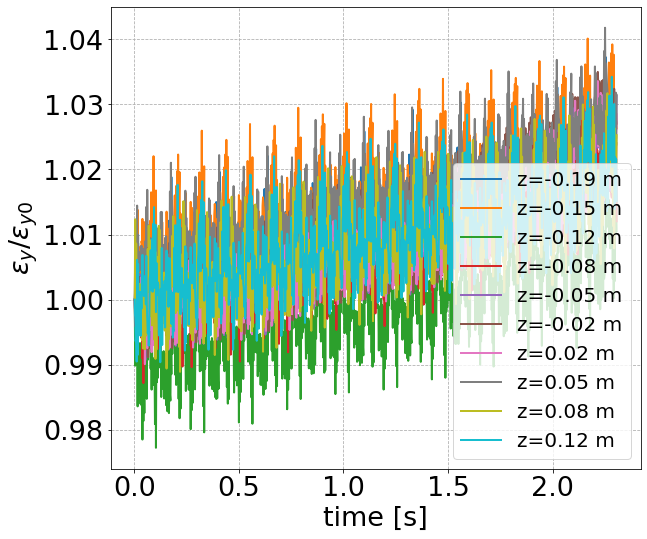

In [118]:
selected_index = np.linspace(0, 180, 11)
print(selected_index)
for i in selected_index[:-1]:
    i = int(i)
    selected_slice = int(selected_slice)
    plt.plot(tspan, emitY_perSlice_dict[f'slice {i}']/ emitY_perSlice_dict[f'slice {i}'][0], label=f'z={new_z_centers[i]:.2f} m')
plt.ylabel(r'$\epsilon_y / \epsilon_{y0}$')
plt.xlabel('time [s]')
plt.grid(linestyle='dashed')
plt.legend()


savefig = False
if savefig:
    plt.savefig('eyvsTime_PostProcessed_SelectedSlices.png', bbox_inches='tight')

### Compute the growth rate, for each slice

After removing the first and last 150 slices and performin a moving average with window 20 (slices).

In [119]:
dey_perSlice = [] # slope of the linear fit
dey_err_perSlice = [] # the error of the slope of the fit


for index, selected_slice in enumerate(new_z_centers):
    # linear fit
    [m_y, b_y], cov_y = np.polyfit(tspan, emitY_perSlice_dict[f'slice {index}'], 1, cov=True)
    err_y = np.sqrt(np.diag(cov_y))
    dey_perSlice.append(m_y)
    dey_err_perSlice.append(err_y[0])

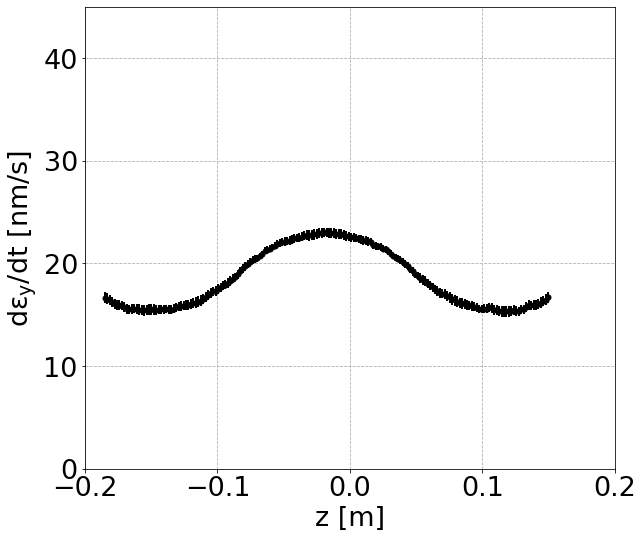

In [121]:
plt.errorbar(new_z_centers, np.array(dey_perSlice)*1e9, yerr=np.array(dey_err_perSlice)*1e9 , marker='o', c='k')
plt.ylabel(r'$\mathrm{d\epsilon_y / dt \ [nm/s]}$')
plt.xlabel('z [m]')
plt.grid(linestyle='dashed')

plt.ylim(0, 90)
#plt.ylim(0,45)
plt.xlim(-0.2, 0.2)


savefig = False
if savefig:
    plt.savefig('deyvsSlice_postProcessed.png', bbox_inches='tight')